Forked from ilovescience's great kernel. Using this as a learning opportunity as it's my first journey into computer vision and fast.ai

# Diabetic Retinopathy 

Diabetic retinopathy (DR), also known as diabetic eye disease, is a medical condition in which damage occurs to the retina due to diabetes mellitus. It is a leading cause of blindness. Diabetic retinopathy affects up to 80 percent of those who have had diabetes for 20 years or more. Diabetic retinopathy often has no early warning signs. **Retinal (fundus) photography with manual interpretation is a widely accepted screening tool for diabetic retinopathy**, with performance that can exceed that of in-person dilated eye examinations. 

The below figure shows an example of a healthy patient and a patient with diabetic retinopathy as viewed by fundus photography ([source](https://www.biorxiv.org/content/biorxiv/early/2018/06/19/225508.full.pdf)):

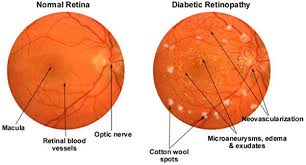

An automated tool for grading severity of diabetic retinopathy would be very useful for accerelating detection and treatment. Recently, there have been a number of attempts to utilize deep learning to diagnose DR and automatically grade diabetic retinopathy. This includes a previous [competition](https://kaggle.com/c/diabetic-retinopathy-detection) and [work by Google](https://ai.googleblog.com/2016/11/deep-learning-for-detection-of-diabetic.html). Even one deep-learning based system is [FDA approved](https://www.fda.gov/NewsEvents/Newsroom/PressAnnouncements/ucm604357.htm). 

Clearly, this dataset and deep learning problem is quite important. 

# A look at the data:

Data description from the competition:

>You are provided with a large set of high-resolution retina images taken under a variety of imaging conditions. A left and right field is provided for every subject. >Images are labeled with a subject id as well as either left or right (e.g. 1_left.jpeg is the left eye of patient id 1).
>
>A clinician has rated the presence of diabetic retinopathy in each image on a scale of 0 to 4, according to the following scale:
>
>0 - No DR
>
>1 - Mild
>
>2 - Moderate
>
>3 - Severe
>
>4 - Proliferative DR
>
> Your task is to create an automated analysis system capable of assigning a score based on this scale. Like any real-world data set, you will encounter noise in both the images and labels. Images may contain artifacts, be out of focus, underexposed, or overexposed. A major aim of this competition is to develop robust algorithms that can function in the presence of noise and variation.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.vision import *
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import os

Import RAdam optimizer for use later:

In [ ]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss

In [ ]:
if not os.path.exists('/tmp/.cache/torch/checkpoints/'):
        os.makedirs('/tmp/.cache/torch/checkpoints/')
!cp '../input/resnet50/resnet50.pth' '/tmp/.cache/torch/checkpoints/resnet50-19c8e357.pth'

os.listdir('../input')

In [ ]:
print('Make sure cudnn is enabled:', torch.backends.cudnn.enabled)

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

SEED = 999
seed_everything(SEED)

## Reading data and Basic EDA

Here I am going to open the dataset with pandas, check distribution of labels.

In [ ]:
base_image_dir = os.path.join('..', 'input/aptos2019-blindness-detection/')
train_dir = os.path.join(base_image_dir,'train_images/')
df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
df['path'] = df['id_code'].map(lambda x: os.path.join(train_dir,'{}.png'.format(x)))
df = df.drop(columns=['id_code'])
df = df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
df.head(5)

In [ ]:
print(f"There are {len(df)} images")

This is actually very small. The [previous competition](https://kaggle.com/c/diabetic-retinopathy-detection) had ~35k images, which supports the idea that pretraining on that dataset may be quite beneficial.

The dataset is highly imbalanced, with many samples for level 0, and very little for the rest of the levels:

In [ ]:
df['diagnosis'].value_counts()

In [ ]:
df['diagnosis'].hist(figsize = (10, 5))

Let's look at an example image:

In [ ]:
from PIL import Image

im = Image.open(df['path'][1])
width, height = im.size
print(width,height) 
im.show()
plt.imshow(np.asarray(im))

The images are actually quite big. We will resize to a much smaller size.

In [ ]:
bs = 64 # smaller batch size is better for training, but may take longer
sz = 224

## Data preprocessing

Crop and process the images, courtesy of this kernel: https://www.kaggle.com/taindow/pre-processing-train-and-test-images

More preprocessing info here: https://www.kaggle.com/taindow/be-careful-what-you-train-on

In [ ]:
def circle_crop(path, sigmaX=10):   
    """
    Create circular crop around image center   
    """    
       
    img = cv2.imread(path)
    img = crop_image_from_gray(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted ( img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def crop_image_from_gray(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image = cv2.resize(image, (sz, sz))
    image = cv2.addWeighted( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

View the results of `load_ben_color`:

In [ ]:
%%time

NUM_SAMP=7
fig = plt.figure(figsize=(24, 16))

for class_id in sorted(df['diagnosis'].unique()):
    for i, (idx, row) in enumerate(df.loc[df['diagnosis'] == class_id].sample(NUM_SAMP, random_state=SEED).iterrows()):
        ax = fig.add_subplot(5, NUM_SAMP, class_id * NUM_SAMP + i + 1, xticks=[], yticks=[])
        path=f"{row['path']}"
        image = load_ben_color(path)

        plt.imshow(image)
        ax.set_title('%d' % class_id )

In [ ]:
# Subclass ImageList to use our own image opening function
class MyImageItemList(ImageList):
    def open(self, fn:PathOrStr)->Image:
        img = load_ben_color(fn.replace('/./','').replace('//','/'))
        
        # This ndarray image has to be converted to tensor before passing on as fastai Image - we can use pil2tensor
        return vision.Image(pil2tensor(img, np.float32).div_(255))
    
# Create list of transformations and our imageDataBunch object
tfms = get_transforms(do_flip=True,flip_vert=True,max_rotate=360,max_warp=0,max_zoom=1.1,max_lighting=0.1,p_lighting=0.5)
data = (MyImageItemList.from_df(df=df,path='./',cols='path') # get dataset
        .split_by_rand_pct(0.2) # split 20% of data into validation set
        .label_from_df(cols='diagnosis',label_cls=FloatList)
        .transform(tfms,size=sz,resize_method=ResizeMethod.SQUISH,padding_mode='zeros')
        .databunch(bs=bs,num_workers=4) # look into more
        .normalize(imagenet_stats)) # look into more

Check that the imageDataBunch turned out okay:

In [ ]:
data.show_batch(rows=3, figsize=(7,7))

# Training (Transfer learning)

The Kaggle competition uses Cohen's quadratically weighted kappa. This is a better metric when dealing with imbalanced datasets like this one, and for measuring inter-rater agreement for categorical classification (the raters being the human-labeled dataset and the neural network predictions). Here is an implementation based on the scikit-learn's implementation, but converted to a pytorch tensor, as that is what fast.ai uses.

In [ ]:
from sklearn.metrics import cohen_kappa_score
def quadratic_kappa(y_hat, y):
    return torch.tensor(cohen_kappa_score(torch.round(y_hat), y, weights='quadratic'),device='cuda:0')

We use transfer learning, where we retrain the last layers of a pretrained neural network. I use the ResNet50 architecture trained on the ImageNet dataset, which has been commonly used for pre-training applications in computer vision. fast.ai makes it quite simple to create a model and train:

In [ ]:
learn = cnn_learner(data, base_arch=models.resnet50, metrics=[quadratic_kappa])
# optimizer = RAdam(learn.model.parameters(), lr=0.001)

learn.summary()

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Here we can see that the loss decreases fastest around `lr=2e-2` so that is what we will use to train.

In [ ]:
# callbacks = [callbacks.SaveModelCallback(learn, every='epoch', monitor='valid_loss')]
learn.fit_one_cycle(20, 2e-2)#, callbacks=callbacks)

In [ ]:
learn.save('stage-1')

learn.recorder.plot_losses()
learn.recorder.plot_metrics()
learn.recorder.plot_lr(show_moms=True)

In [ ]:
learn.unfreeze()

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))#, callbacks=callbacks)

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

In [ ]:
learn.export()
learn.save('stage-2')

In [ ]:
learn.show_results()

# Model evaluation

In [ ]:
preds, y, losses = learn.get_preds(with_loss=True)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

## Optimize the Metric

Optimizing the quadratic kappa metric was an important part of the top solutions in the previous competition. Thankfully, @abhishek has already provided code to do this for us. We will use this to improve the score.

In [ ]:
valid_preds = learn.get_preds(ds_type=DatasetType.Valid)

In [ ]:
import numpy as np
import pandas as pd
import os
import scipy as sp
from functools import partial
from sklearn import metrics
from collections import Counter
import json

In [ ]:
class OptimizedRounder(object):
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = metrics.cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')
        print(-loss_partial(self.coef_['x']))

    def predict(self, X, coef):
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [ ]:
optR = OptimizedRounder()
optR.fit(valid_preds[0],valid_preds[1])

In [ ]:
coefficients = optR.coefficients()
print(coefficients)

# Submission

In [ ]:
sample_df = pd.read_csv('../input/aptos2019-blindness-detection/sample_submission.csv')
sample_df.head()

In [ ]:
learn.data.add_test(MyImageItemList.from_df(sample_df,'../input/aptos2019-blindness-detection',folder='test_images',suffix='.png'))

In [ ]:
preds, y = learn.get_preds(ds_type=DatasetType.Test)

In [ ]:
test_predictions = optR.predict(preds, coefficients)

In [ ]:
sample_df.diagnosis = test_predictions.astype(int)
sample_df.head()

In [ ]:
sample_df.to_csv('submission.csv',index=False)